Install datasets from :  
https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/data  
https://huggingface.co/datasets/ccmusic-database/music_genre

In [ ]:
import pandas as pd
import os
import numpy as np
import pickle

In [95]:
from datasets import load_dataset

ds = load_dataset(r'datasets--ccmusic-database--music_genre')

In [96]:
df = ds['train'].to_pandas()

C:\Users\fidyt\AppData\Local\Temp\ipykernel_1772\455585888.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_bytes = df.loc[0][0]['bytes']


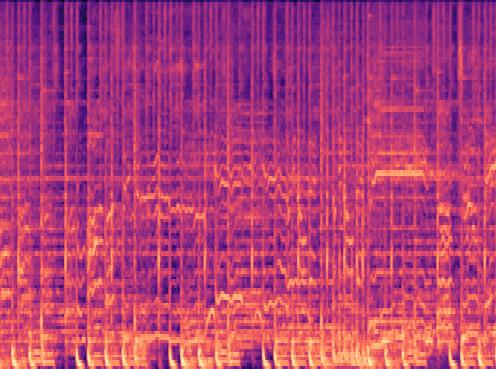

In [97]:
from PIL import Image
import io
img_bytes = df.loc[0][0]['bytes']
img = Image.open(io.BytesIO(img_bytes))
img

In [98]:
df = df[['mel','sec_level_label']].rename(columns={'mel':'mel',"sec_level_label":'label'})
df

,mel,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,8
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,8
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4
...,...,...
29095,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1
29096,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,8
29097,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,8
29098,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [99]:
def binary_to_pil(bin):
    return Image.open(io.BytesIO(bin))

In [100]:
df['mel'] = df['mel'].apply(lambda x:binary_to_pil(x['bytes']))

In [102]:
label_info ={0: 'Symphony',
                1: 'Opera',
                2: 'Solo',
                3: 'Chamber',
                4: 'Pop',
                5: 'Dance_and_house',
                6: 'Indie',
                7: 'Soul_or_RnB',
                8: 'Rock'}

df['label'] = df['label'].apply(lambda x:label_info.get(x,'Unknown'))

In [103]:
df.label.unique()

array(['Pop', 'Rock', 'Soul_or_RnB', 'Chamber', 'Symphony',
       'Dance_and_house', 'Indie', 'Solo', 'Opera'], dtype=object)

In [105]:
df

,mel,label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Pop
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Pop
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Rock
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Rock
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Pop
...,...,...
29095,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Opera
29096,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Rock
29097,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Rock
29098,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Solo


In [113]:
df.mel.iloc[0].size

(496, 369)

In [101]:
dir =r'genres_original'
tracks= []
labels = []
for i in os.listdir(dir):
    for y in os.listdir(os.path.join(dir,i)):
        tracks.append(os.path.join(dir,i,y))
        labels.append(i)

mds = pd.DataFrame(zip(tracks,labels),columns=['track_path','label'])

In [114]:
import librosa

def to_spectrogram(wav):
    wav = os.path.abspath(str(wav))
    y,sr = librosa.load(wav,sr=22050)
    spectrogram = librosa.feature.melspectrogram(y=y,sr=sr,n_mels=369)
    spectrogram_db = librosa.power_to_db(spectrogram,ref=np.max)
    img_data=((spectrogram_db - spectrogram_db.min()) / (spectrogram_db.max() - spectrogram_db.min()) * 255).astype(np.uint8)
    img = Image.fromarray(np.flipud(img_data))

    return img

In [115]:
def safe_feature(wav):
    try:
        return to_spectrogram(wav)
    except Exception as e:
        return None

In [116]:
mds['mel']=mds['track_path'].map(lambda x: safe_feature(x))


C:\Users\fidyt\AppData\Local\Temp\ipykernel_1772\138406953.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y,sr = librosa.load(wav,sr=22050)
c:\Users\fidyt\Desktop\ML\MLvenv\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [117]:
print(mds.mel.isna().sum())
mds = mds.dropna(subset=['mel'])

1


In [118]:
mds = mds[['mel','label']]

In [ ]:
cdf = pd.concat([df,mds])

In [133]:
cdf['mel'] = df['mel'].apply(lambda x: x.resize((224,244)))

In [134]:
cdf.to_pickle('cleaned_data.pkl')